In [1]:
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import locale
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

'es_ES.UTF-8'

In [2]:
def CrearGrafico(df, Ultima_Importacion, Valor, Titulo):
    Grafico = df.plot(kind = 'line'
                      , linestyle='-'
             , linewidth=2.0
             , color=['red','blue']
             , figsize = (14.36 / 1.5, 7.09 / 1.5))

    Grafico.legend(loc = 'upper center'
               , bbox_to_anchor = (0.5, 1.15)
               , ncol = 3
               , fancybox = False
               , shadow = True
               , fontsize = 12)
    Grafico.tick_params(left = False, bottom = False)
    Grafico.grid(axis='y',alpha=0.25)

    [spine.set_visible(False) for spine in plt.gca().spines.values()]

    plt.gca().set_ylabel(str(Valor) + ' ' + Titulo 
                         , color = '#909090'
                     #    , y = 0.75
                         , fontsize = 15)

    plt.gca().set_xlabel('* Datos actualizados a: ' + Ultima_Importacion
                         , color = '#909090'
                         , x = 0.85
                         , fontsize = 10)

    Grafico.fmt_xdata = mdates.DateFormatter('%m')
    plt.xticks(rotation = 0)

    plt.show()
    plt.close()
    
    return Grafico

def getDatos(tabla):
    Url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/' + tabla + '.csv'
    df = pd.read_csv(Url, sep = ',', header = 0)
    df.drop(['Province/State','Lat','Long'], axis='columns', inplace=True)
    df = df.rename(columns = {'Country/Region':'Pais'})

    df = df[(df['Pais'] == 'Spain') | (df['Pais'] == 'Italy')]
    df.set_index('Pais', inplace = True)
    df = df.transpose()

    df.reset_index(inplace = True)
    df = df.rename(columns = {'index':'Fecha'})
    df['Fecha'] =  pd.to_datetime(df['Fecha'], format = '%m/%d/%y').dt.strftime('%d-%b')

    for i in df['Fecha'][-1:]:
        Ultima_Importacion = i
        
    for i in df['Spain'][-1:]:
        Valor = i

    df.set_index('Fecha', inplace = True)
    
    return df, Ultima_Importacion, Valor

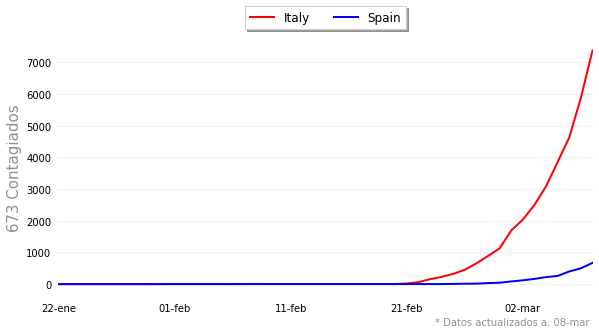

In [3]:
df, Ultima_Importacion, Valor = getDatos('time_series_19-covid-Confirmed')

CrearGrafico(df, Ultima_Importacion, Valor, 'Contagiados')

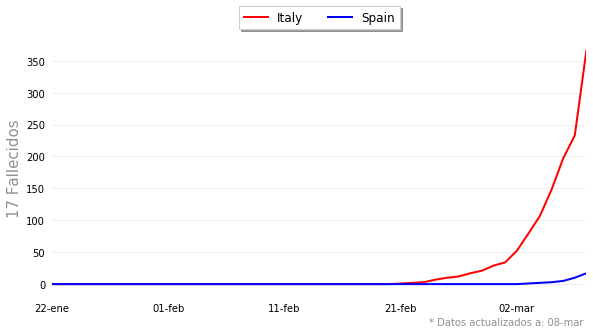

In [4]:
df, Ultima_Importacion, Valor = getDatos('time_series_19-covid-Deaths')

CrearGrafico(df, Ultima_Importacion, Valor, 'Fallecidos')

